In [ ]:
import os
import tensorflow as tf
import zipfile
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [ ]:
zip_file_path = "/content/drive/MyDrive/all_food_classes.zip"

extract_path = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
train_dir = "/content/all_food_classes/train/"
test_dir = "/content/all_food_classes/test/"

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=(224, 224),
                                                                batch_size=32,
                                                                shuffle=True,
                                                                seed=42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                shuffle=False,
                                                                image_size=(224, 224),
                                                                batch_size=32,
                                                                seed=42)

Found 75750 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
def view_image(target_dir, target_class):

  target_folder = target_dir + target_class

  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img

Image shape: (512, 512, 3)


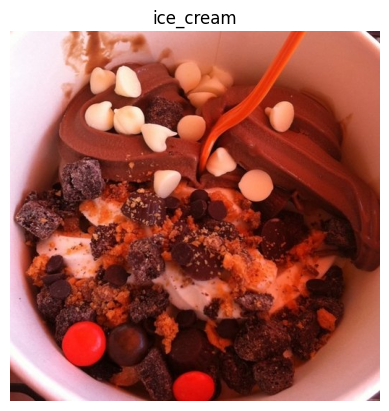

In [ ]:
img = view_image(target_dir="all_food_classes/train/",
                        target_class="ice_cream")

In [ ]:
print(train_data.class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [ ]:
class_names = train_data.class_names

In [ ]:
for images, labels in train_data.take(1):
  print(images.shape)
  print(labels.shape)

(32, 224, 224, 3)
(32, 101)


In [ ]:
train_one_sample = train_data.take(1)

In [ ]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
for image, label in train_data.take(1):
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Labels shape: {label.shape}
  Labels datatype: {label.dtype}
  """)


  Image shape: (32, 224, 224, 3)
  Image datatype: <dtype: 'float32'>
  Labels shape: (32, 101)
  Labels datatype: <dtype: 'float32'>
  


In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=255.0>)

In [ ]:
def create_tensorboard_callback(dir_name, experiment_name):
  import datetime
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

# constants
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = len(class_names)

# base model
base_model = EfficientNetB0(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
base_model.trainable = False

# Functional model
inputs = layers.Input(shape=INPUT_SHAPE, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)

x = layers.Dense(NUM_CLASSES, name="output_layer")(x)
outputs = layers.Activation("softmax", name="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Activation)                 │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
tf.get_logger().setLevel('ERROR')

history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=7,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20240809-080452
Epoch 1/7
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 98ms/step - accuracy: 0.4320 - loss: 2.4650 - val_accuracy: 0.6176 - val_loss: 1.4387
Epoch 2/7


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6314 - val_loss: 1.4315
Epoch 3/7
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 192s 79ms/step - accuracy: 0.6266 - loss: 1.4510 - val_accuracy: 0.7283 - val_loss: 1.0277
Epoch 4/7
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6674 - val_loss: 1.2514
Epoch 5/7
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 175s 74ms/step - accuracy: 0.6658 - loss: 1.2900 - val_accuracy: 0.7500 - val_loss: 0.9321
Epoch 6/7
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6864 - val_loss: 1.1272
Epoch 7/7
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 216s 91ms/step - accuracy: 0.6859 - loss: 1.1959 - val_accuracy: 0.6704 - val_loss: 1.2278


In [ ]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 75ms/step - accuracy: 0.6820 - loss: 1.1827


[1.1211172342300415, 0.6990495324134827]

In [ ]:
def create_model():

# constants
  INPUT_SHAPE = (224, 224, 3)
  NUM_CLASSES = len(class_names)

# base model
  base_model = EfficientNetB0(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
  base_model.trainable = False

# Functional model
  nputs = layers.Input(shape=INPUT_SHAPE, name="input_layer")
  x = base_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)

  x = layers.Dense(NUM_CLASSES, name="output_layer")(x)
  outputs = layers.Activation("softmax", name="softmax")(x)
  model = tf.keras.Model(inputs, outputs)

  return model


# 2. new version of the original model
created_model = create_model()
created_model.compile(loss="categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 73ms/step - accuracy: 0.6683 - loss: 1.2242


In [ ]:
save_dir = "07_efficientnetb0_feature_extract_model.keras"
model.save(save_dir)

In [ ]:
save_dir = "/content/drive/MyDrive/07_efficientnetb0_feature_extract_model.keras"
model.save(save_dir)

In [ ]:
# Loading model previously saved
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Checking loaded model performance
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 71ms/step - accuracy: 0.6739 - loss: 1.2064


[1.124316930770874, 0.6967920660972595]

In [ ]:
loaded_saved_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Activation)                 │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,437,720 (16.93 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 258,768 (1010.82 KB)

In [ ]:
# EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/model.keras"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
loaded_saved_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(0.0001),
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data,
                                                        epochs=100,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)),
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20240809-083818
Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 234s 89ms/step - accuracy: 0.7102 - loss: 1.0908 - val_accuracy: 0.6894 - val_loss: 1.1564 - learning_rate: 1.0000e-04
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7021 - val_loss: 1.0801 - learning_rate: 1.0000e-04
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 228s 81ms/step - accuracy: 0.7256 - loss: 1.0327 - val_accuracy: 0.7638 - val_loss: 0.8745 - learning_rate: 1.0000e-04
Epoch 4/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7108 - val_loss: 1.0640 - learning_rate: 1.0000e-04
Epoch 5/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 170s 72ms/step - accuracy: 0.7324 - loss: 1.0064 - val_accuracy: 0.7953 - val_loss: 0.7775 - learning_rate: 1.0000e-04
Epoch 6/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7315 - val_loss: 0.9814 - learning_rate: 1.0000e-04
Epoch 7/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7402 - loss: 0.9854
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 ━━━━━━━━━━

In [ ]:
save_dir = "/content/drive/MyDrive/07_efficientnetb0_fine_tuned.keras"
loaded_saved_model.save(save_dir)

In [ ]:
# Loading in fine-tuned model
loaded_fine_tuned_model = tf.keras.models.load_model("/content/drive/MyDrive/07_efficientnetb0_fine_tuned.keras")

In [ ]:
loaded_fine_tuned_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Activation)                 │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,437,720 (16.93 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 258,768 (1010.82 KB)

In [ ]:
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 69s 76ms/step - accuracy: 0.7145 - loss: 1.0497


[0.9744066596031189, 0.7343762516975403]